In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve

2025-03-02 13:44:48.376626: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 13:44:48.384931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740919488.393691   16045 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740919488.396311   16045 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 13:44:48.406495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
df=pd.read_csv("../datasets/sensor.csv")
#sensors_to_drop = ['Unnamed: 0', 'timestamp','sensor_15', 'sensor_50']
sensors_to_drop = ['Unnamed: 0','sensor_15', 'sensor_50']
df = df.drop(columns=sensors_to_drop)

sensor_cols = df.columns[df.isnull().any()].tolist()
df[sensor_cols] = df[sensor_cols].interpolate(method='linear')

# If any remaining NaNs, use forward/backward fill
df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
df[sensor_cols] = df[sensor_cols].fillna(method='bfill')
y=df["machine_status"]
X=df.drop(columns=['machine_status'])

/tmp/ipykernel_16045/1443057295.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
/tmp/ipykernel_16045/1443057295.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='bfill')


In [4]:
first_broken_idx = y[y == "BROKEN"].index[0]
df.iloc[:first_broken_idx-200].to_csv("../datasets/initial_data.csv",index=False)
X=X.drop(columns=["timestamp"])
# 2. Isolate normal data up to first BROKEN for training
train_X = X.iloc[:first_broken_idx-200].values
n_features = train_X.shape[1]  # number of sensors (~50)

# 3. Normalize the training data
train_mean = train_X.mean(axis=0)
train_std = train_X.std(axis=0)
train_X_normalized = (train_X - train_mean) / train_std

In [23]:
class Autoencoder(Model):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(n_features,)),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')  # bottleneck
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(n_features, activation='linear')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
# 5. Create and compile the model
autoencoder = Autoencoder(n_features)
autoencoder.compile(optimizer='adam', loss='mse')

/home/henrik/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:

# 6. Train the autoencoder
history = autoencoder.fit(
    train_X_normalized, 
    train_X_normalized,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - loss: 0.9160

2025-02-24 12:25:26.067752: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_252', 40 bytes spill stores, 40 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.8579 - val_loss: 1.5967
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6740 - val_loss: 1.3746
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4923 - val_loss: 1.2744
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4102 - val_loss: 1.2398
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3556 - val_loss: 1.2201
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3431 - val_loss: 1.2083
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3248 - val_loss: 1.2003
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3035 - val_loss: 1.1961
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2878 - val_loss: 1.1863
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2819 - val_loss: 1.1882
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2838 - val_loss: 1.1843
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2659 - val_loss: 1.1806

In [28]:
broken_indices = y[y == "BROKEN"].index
second_broken_idx = broken_indices[1]
test_start_idx = max(0, second_broken_idx - 200)
test_X = X.iloc[test_start_idx:second_broken_idx + 1].values
test_X_normalized = (test_X - train_mean) / train_std

# 8. Get reconstructions and calculate reconstruction error
reconstructions = autoencoder.predict(test_X_normalized)
mse = np.mean(np.square(test_X_normalized - reconstructions), axis=1)
offset=len(df)-len(mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


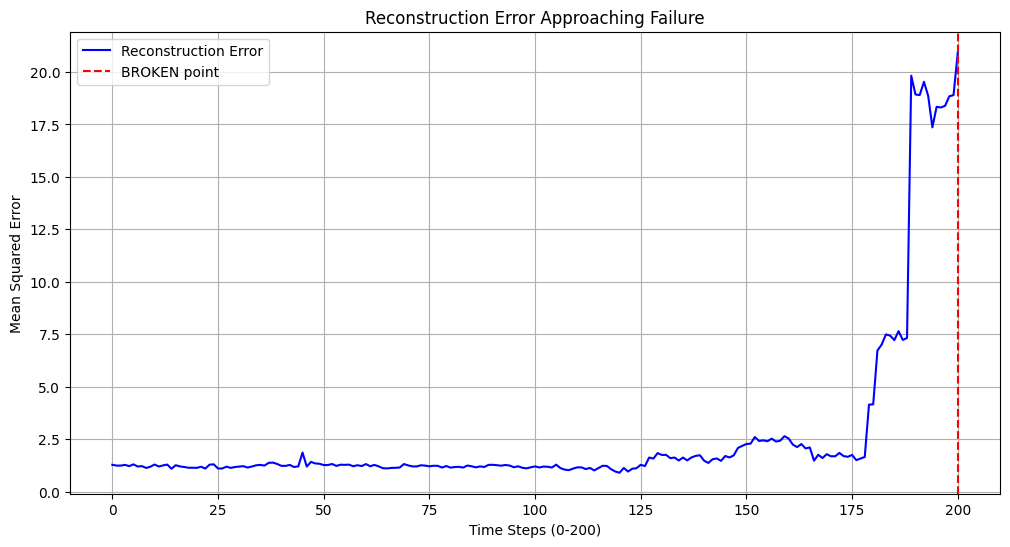

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(mse)), mse, 'b-', label='Reconstruction Error')
#plt.scatter(y[y == "BROKEN"].index-offset, 400+np.zeros(len(y[y == "BROKEN"].index), dtype=int))  # Initialize an array of zeros), 'b-', label='Reconstruction Error')
#plt.scatter(y[y == "RECOVERING"].index-offset, 200+np.zeros(len(y[y == "RECOVERING"].index), dtype=int))  # Initialize an array of zeros), 'b-', label='Reconstruction Error')
plt.axvline(x=200, color='r', linestyle='--', label='BROKEN point')
plt.title('Reconstruction Error Approaching Failure')
plt.xlabel('Time Steps (0-200)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()